# NLP Lab 2


In [5]:
!pip install --upgrade cython
!pip install ruamel-yaml-conda
!pip install pymystem3 selenium html2text requests beautifulsoup4 atlas json2xml --use-feature=2020-resolver
!brew install chromedriver

     |████████████████████████████████| 983 kB 1.1 MB/s eta 0:00:01
  Using cached ruamel_yaml_conda-0.15.80.tar.gz (202 kB)
    ERROR: Command errored out with exit status 1:
     command: /usr/local/Caskroom/miniconda/base/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/h9/d_5kr6xn59dc2d8szjycvyph0000gn/T/pip-install-guwkraq9/ruamel-yaml-conda/setup.py'"'"'; __file__='"'"'/private/var/folders/h9/d_5kr6xn59dc2d8szjycvyph0000gn/T/pip-install-guwkraq9/ruamel-yaml-conda/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/h9/d_5kr6xn59dc2d8szjycvyph0000gn/T/pip-pip-egg-info-j_ynrwey
         cwd: /private/var/folders/h9/d_5kr6xn59dc2d8szjycvyph0000gn/T/pip-install-guwkraq9/ruamel-yaml-conda/
    Complete output (11 lines):
    Traceback (most recent call last):
      File "<string>", lin

In [6]:
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options

from time import sleep
# import tqdm
from tqdm.notebook import tqdm
import json
import time


import requests
from bs4 import BeautifulSoup
from html2text import html2text

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [7]:
json_filename = "data.json"
categories = ["transport", "auto", "health", "incidents"]

In [8]:
chrome_driver_path = "/opt/homebrew/bin/chromedriver" #!which chromedriver - for get path in system

## Парсинг новостного портала


Поскольку новостной агрегатор который я использовал в Лабе 1 теперь является запрщенным, я принял решение перейти на парсинг данных с популярного локального портала nn.ru

In [31]:
# The function extracts article data from www.nn.ru and writes it in JSON format to out_filename
# The extracted data is: 
# - article link (article_id) 
# - article title 
# - article category
# - article tags 
# - article text
# The category and number of articles is specified by categories and article_num respectively

def parse_nnru(article_num, categories, out_filename, progress_bar=True):
    # progress bar setup   
    if progress_bar:
        category_bar = tqdm(range(len(categories)), desc = 'Category progress')
        article_bar = tqdm(range(article_num), desc = 'Article progress', leave = False)

    # create output json file
    with open(out_filename,'w', encoding="utf-8") as file:
        pass
    
    # set Chrome options and preferences
    prefs = {"profile.managed_default_content_settings.images": 2,
             "profile.default_content_settings.cookies": 2}
    chrome_options = Options()
    chrome_options.add_extension('adblock.crx')
    chrome_options.add_experimental_option("prefs",prefs) 
    chrome_options.add_argument('--disable-application-cache')
    
    driver = Chrome(executable_path=chrome_driver_path, chrome_options=chrome_options)
    driver.implicitly_wait(10)
    driver.close()
    print("Current session is {}".format(driver.session_id))
    driver.switch_to.window(driver.window_handles[0])
    
    driver.get('chrome-extension://gighmmpiobklfepjocnamgkkbiglidom/options.html')
    driver.find_element_by_id('acceptable_ads').click() # adblock customization
       
    for category in categories:
        # progress bar
        if progress_bar:
            category_bar.update(1)
            article_bar.reset()
            
        article_count = 0
        page = 1       
        while(1):
            while_break_flag = False # used to break while(1) from the nested for-loop
            
            driver.get(f'https://www.nn.ru/text/?rubric={category}&page={page}')           
            
            #for element in driver.find_elements_by_xpath("//article"):
            for element in driver.find_elements_by_xpath("//*[@class='_3-SyJ']"): # tags with this specific class contain article previews
                json_dict = {}            
                # article's link  
                json_dict['article_id'] = element.find_element_by_tag_name('a').get_attribute('href')
                
                soup = BeautifulSoup(requests.get(json_dict['article_id']).text, "lxml")            

                # article's title 
                json_dict['title'] = ''
                title = soup.find('h1', attrs={'itemprop': 'headline'}, recursive=True)
                if title is None:
                    continue
                else:
                    json_dict['title'] = title.getText()
                
                # article's category  
                json_dict['category'] = category

                # article's tags        
                json_dict['tags'] = []
                div_tags = soup.find('div', attrs={'class': '_2TvYC'}, recursive=True) # <div class="_2TvYC"> contains tags of an article
                if div_tags is not None: # some articles may not have tags at all            
                    div_tags_children = div_tags.findChildren('span')
                    for child in div_tags_children: # iterate over <span> children
                        json_dict['tags'].append(child.getText()) # transform type bs4.element.Tag into str and append to a list
                else:
                    #continue
                    pass
                
                # article's text 
                json_dict['text'] = ''
                div_article = soup.find('div', attrs={'itemprop': 'articleBody'}) # find a <div>, which contains the article itself
                if div_article is None: # if the div with an article hasn't been found
                    continue                
                for figure_tag in div_article.find_all('figure', attrs={'itemscope': 'itemscope'}):
                    figure_tag.extract() # remove all <figure itemscope='itemscoppe'> tags, which contain images and image-related text
                text = ''
                for paragraph in div_article.find_all(['p', 'li'], attrs={'class': ''}):
                    json_dict['text'] += paragraph.getText(separator=" ") + ' ' # s
                    # NOTE: there may be double spaces in some places
                
                # write data to output json file                
                with open(out_filename,'a', encoding="utf-8") as file:
                    file.write(json.dumps(json_dict, ensure_ascii=False) + '\n')
                
                # progress bar
                if progress_bar:
                    article_bar.update(1)
    
                # check whether the number of articles is sufficient
                article_count+=1
                if article_count >= article_num:
                    while_break_flag = True
                    break
                
            if while_break_flag is True: # break the while-loop from the inner for-loop if the amount of fetched articles is sufficient
                break
            else:
                page+= 1 # otherwise, fetch articles from the next page    
        
    driver.quit()


In [32]:
parse_nnru(1000, categories, json_filename)

Current session is 72247f869e9456b5048873d35910c51b


In [33]:
data = pd.read_json(json_filename, lines=True)
data

,article_id,title,category,tags,text
0,https://www.nn.ru/text/gorod/2022/03/27/70535720/,Нижегородец продает на «Авито» бигмак по цене ...,transport,"[«Авито», «индекс Биг Мака», странные товары с...",Жители Нижегородской области могут приобрести ...
1,https://www.nn.ru/text/transport/2022/03/27/70...,Часть улиц Студеная и Максима Горького в Нижне...,transport,"[Нижний Новгород, метро, перекрытие движения]",Рабочие перекрыли участки улиц Студеная и Макс...
2,https://www.nn.ru/text/house/2022/03/27/70532957/,"14 ошибок при стирке, которые обходятся вам сл...",transport,"[лайфхаки, стиральная машинка, уборка, стирка]","Вот уж кому было несладко, так это нашим бабуш..."
3,https://www.nn.ru/text/education/2022/03/27/70...,Новый сезон битвы молодых ученых Science Slam ...,transport,"[Science Slam, ННГУ им. Лобачевского, наука]",Открыт прием заявок на участие в битве молодых...
4,https://www.nn.ru/text/entertainment/2022/03/2...,«На лавочке семечки щелкать — не для меня»: ка...,transport,"[pole dance, таксистка, танцы на пилоне]","Днем Евгения Лоскутова крутит руль иномарки, а..."
...,...,...,...,...,...
3995,https://www.nn.ru/text/health/2022/02/08/70428...,«Поликлиники превращаются в рассадники инфекци...,incidents,"[коронавирус, Алексей Кокунин, омикрон]",За неделю в Нижегородской области суточный при...
3996,https://www.nn.ru/text/health/2022/02/07/70429...,В Нижнем Новгороде начали оформлять больничные...,incidents,"[больничный, коронавирус]",С сегодняшнего дня нижегородцы смогут открыть...
3997,https://www.nn.ru/text/health/2022/02/07/70428...,Дистанта не будет. Оперштаб пока не собирается...,incidents,"[Нижний Новгород, оперштаб по борьбе с коронав...",Оперативный штаб по коронавирусу решил пока не...
3998,https://www.nn.ru/text/gorod/2022/02/07/70428146/,Выпуск программы «Непутевые заметки» сняли в Н...,incidents,"[«Непутевые заметки», Нижний Новгород]",Выпуск программы «Непутевые заметки» сняли в Н...


## Lab 2


In [34]:
!pip install nltk sklearn wordcloud pymorphy2 stop_words

     |████████████████████████████████| 1.5 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 220 kB 346 kB/s eta 0:00:01
     |████████████████████████████████| 55 kB 5.1 MB/s eta 0:00:011
     |████████████████████████████████| 289 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 2.6 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=158439 sha256=fbbf766ffcc4d1f91a9ea9675547221db32f5576ef5aa4dc3407bb1f75bff6d3
  Stored in directory: /Users/irazzivin/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32915 sha256=ce9b189eac4c5e03965e18124d24fb52387519a6c8d92ff3aaa19411d8b0e5c0
  Stored in directory: /Users/irazzivin/Library/Caches/pip/wheels/eb/03/0d/3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
Succes

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/irazzivin/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/irazzivin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [36]:
raw_data = pd.read_json(json_filename, lines=True)

### 1. Предпроцессинг текста

In [37]:
# the function preprocesses input text, i. e. removes digits, punctuation, special characters, etc.
# and converts words to normal form.
# As for return value, the preprocessed text is either left as is, tokenized by words or tokenized by sentences.

def preprocess_text(input_text, tokenize_by='sentence'):
    
    if tokenize_by != 'word' and tokenize_by != 'sentence' and tokenize_by != 'text':
        raise Exception("tokenize_by can only be 'word', 'sentence' or 'text'")
    
    # copy a string
    output_text = input_text[:]
    
    # convert letters to lowercase
    output_text = output_text.lower() 
    
    # remove multiple spaces 
    output_text = re.sub(r' +', 
                         ' ', 
                         output_text)
    
    # remove links
    output_text = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-—_=#])*', 
                                          '', 
                                          output_text)
    
    # remove email addresses
    output_text = re.sub(r'^([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})$', 
                                          '', 
                                          output_text) 

    # remove phone numbers (not working)
    output_text = re.sub(r'^(?:\s*-*\s*\d){8}$', 
                                          '', 
                                          output_text)

    # tokenize sentences
    output_text = sent_tokenize(output_text) 
    
    # remove special characters
    special_chars = ''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])
    regex_special_chars = re.compile(f'[{re.escape(special_chars)}]')
    output_text = [regex_special_chars.sub('', sent) for sent in output_text]
    
    # remove all punctuation
    regex_punct = re.compile(f'[{re.escape(string.punctuation)}]') # punctuation to exclude 
    output_text = [regex_punct.sub('', sent) for sent in output_text]
    
    # remove all digits
    regex_dig = re.compile(f'[{re.escape(string.digits)}]')
    output_text = [regex_dig.sub('', sent) for sent in output_text]
    
    # tokenize words 
    output_text = [word_tokenize(sent) for sent in output_text]
    
    # exclude stop-words
    stop_words_list = stopwords.words('russian') # nltk package
    # stop_words_list = stop_words.get_stop_words('russian') # stop_words package   
    output_text = [[word for word in sent if word not in stop_words_list] for sent in output_text] # kinda unreadable?
    
    # lemmatize (convert words to the base/normal form)
    morph = pymorphy2.MorphAnalyzer()
    output_text = [[morph.parse(word)[0].normal_form for word in sent if word not in stop_words_list] for sent in output_text] 
    
    if tokenize_by == 'word':  
        return output_text
    elif tokenize_by == 'sentence':
        return [' '.join(sent) for sent in output_text]
    elif tokenize_by == 'text':
        return ' '.join([' '.join(sent) for sent in output_text])


### 2. Векторизация текста (совместно с предпроцессингом)

In [38]:
# The function goes through the data from JSON, preprocesses the text of each entry using preprocess_text() function
# and vectorizes the texts using TfidVectorizer()

def vectorize_text_all(raw_input_data):
    raw_input_data_len = raw_input_data.shape[0] # number of rows
    # raw_input_data_len = 100
    texts = []
    y = [] 

    bar = tqdm(range(raw_input_data_len), desc = 'Article progress')
    for i in range(raw_input_data_len):
        texts.append(preprocess_text(raw_input_data['text'][i], tokenize_by='text'))
        y.append(raw_input_data['category'][i])
        bar.update(1)   
    bar.close()

    vectorizer = TfidfVectorizer()    
    X = vectorizer.fit_transform(texts)
    X = X.toarray()
    X = pd.DataFrame(data=X, columns=vectorizer.get_feature_names())
    
    return X, y

In [39]:
X, y = vectorize_text_all(raw_data)

In [81]:
def proc(raw_input_data):
    raw_input_data_len = raw_input_data.shape[0] # number of rows
    raw_input_data_len = 100
    texts = []
    y = [] 

    bar = tqdm(range(raw_input_data_len), desc = 'Article progress')
    for i in range(raw_input_data_len):
        texts.append(preprocess_text(raw_input_data['text'][i], tokenize_by='text'))
        y.append(raw_input_data['category'][i])
        bar.update(1)   
    bar.close()

    Z = pd.DataFrame(data=X, columns=vectorizer.get_feature_names())
    
    return Z
result = proc(raw_data)

NameError: name 'vectorizer' is not defined

In [82]:
X.to_json(r'result.json')

### 3. Применение классических ML-алго

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

train & test наборы данных распределены в пропорции 80/20 соответсвенно. 

Классы сбалансированы и в тестовой, и в обучающей выборке:

<AxesSubplot:>

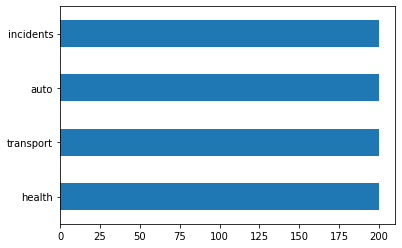

In [41]:
pd.Series(y_test).value_counts().plot(kind='barh')

<AxesSubplot:>

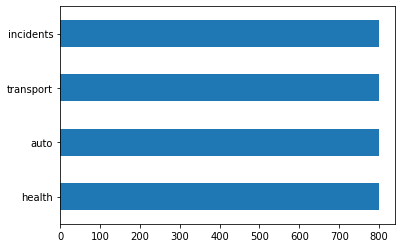

In [42]:
pd.Series(y_train).value_counts().plot(kind='barh')

GridSearchCV используется для подстройки hyperparameter'ов. Лучшие параметры отбираются по наибольшему значению f-1.

#### 3.1 KNN

In [56]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': [2, 4, 8, 16],
    'weights': ['distance', 'uniform'],
    'metric': ['minkowski', 'euclidean']
}

gs_knn = GridSearchCV(
    KNeighborsClassifier(),
    params,
    scoring='f1_micro',
    verbose=3,
    cv=2,
    n_jobs=1,
)

#knn = KNeighborsClassifier(n_neighbors=2)
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] metric=minkowski, n_neighbors=2, weights=distance ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  metric=minkowski, n_neighbors=2, weights=distance, score=0.052, total= 1.1min
[CV] metric=minkowski, n_neighbors=2, weights=distance ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, weights=distance, score=0.066, total= 1.1min
[CV] metric=minkowski, n_neighbors=2, weights=uniform ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV]  metric=minkowski, n_neighbors=2, weights=uniform, score=0.113, total= 1.1min
[CV] metric=minkowski, n_neighbors=2, weights=uniform ................
[CV]  metric=minkowski, n_neighbors=2, weights=uniform, score=0.115, total= 1.1min
[CV] metric=minkowski, n_neighbors=4, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=4, weights=distance, score=0.052, total= 1.5min
[CV] metric=minkowski, n_neighbors=4, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=4, weights=distance, score=0.061, total= 1.4min
[CV] metric=minkowski, n_neighbors=4, weights=uniform ................
[CV]  metric=minkowski, n_neighbors=4, weights=uniform, score=0.128, total= 1.5min
[CV] metric=minkowski, n_neighbors=4, weights=uniform ................
[CV]  metric=minkowski, n_neighbors=4, weights=uniform, score=0.133, total= 1.5min
[CV] metric=minkowski, n_neighbors=8, weights=distance ...............
[CV]  metric=minkowski, n_neighbors=8, weights=distance, score=0.051, tota

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 44.0min finished


{'metric': 'minkowski', 'n_neighbors': 16, 'weights': 'uniform'}

In [59]:
y_pred = gs_knn.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.17      0.11      0.13       305
      health       0.07      0.07      0.07       208
   incidents       0.04      0.05      0.05       153
   transport       0.01      0.02      0.02       134

    accuracy                           0.07       800
   macro avg       0.07      0.06      0.07       800
weighted avg       0.09      0.07      0.08       800



Наблюдается что, KNN по какой-то причине предпочитает класс "авто", значение оценки f1-score сравнительно небольшое.

#### 3.2 Decision tree

In [61]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [4, 8, 16, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 5, 10]
}

gs_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    params,
    scoring='f1_micro',
    verbose=3,
    cv=2,
    n_jobs=10
)

gs_tree.fit(X_train, y_train)
gs_tree.best_params_

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed:  1.3min finished


{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [62]:
y_pred = gs_tree.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.01      0.06      0.01        18
      health       0.00      0.00      0.00        19
   incidents       0.89      0.23      0.37       763
   transport       0.00      0.00      0.00         0

    accuracy                           0.22       800
   macro avg       0.22      0.07      0.09       800
weighted avg       0.85      0.22      0.35       800



В целом, decision tree показало результаты лучше, чем KNN.

#### 3.3 Random forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': [2, 4, 8, 16, 32],
    'max_depth': [4],
    'min_samples_leaf': [1],
    'min_samples_split': [2]
}

gs_rforest = GridSearchCV(
    RandomForestClassifier(random_state=42),
    params,
    scoring='f1_micro',
    verbose=3,
    cv=2,
    n_jobs=10
)

gs_rforest.fit(X_train, y_train)
gs_rforest.best_params_

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done  35 out of  40 | elapsed:    5.7s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:    6.6s finished


{'max_depth': 4,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [65]:
y_pred = gs_rforest.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.01      0.02      0.01        57
      health       0.04      0.08      0.05        95
   incidents       0.59      0.21      0.31       571
   transport       0.02      0.05      0.03        77

    accuracy                           0.17       800
   macro avg       0.17      0.09      0.10       800
weighted avg       0.43      0.17      0.23       800



Довольно странно, у Random Forest результаты хуже, чем у decision tree

#### 3.4 SVM

In [66]:
from sklearn.svm import SVC

params = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.1, 0.01], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}

gs_svm = GridSearchCV(
    SVC(random_state=42),
    params,
    scoring='f1_micro',
    verbose=3,
    cv=2,
    n_jobs=10
)


gs_svm.fit(X_train, y_train)
gs_svm.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed: 21.1min remaining:    0.0s
[Parallel(n_jobs=10)]: Done  54 out of  54 | elapsed: 21.1min finished


{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}

In [67]:
y_pred = gs_svm.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.00      0.00      0.00       113
      health       0.06      0.09      0.07       141
   incidents       0.06      0.03      0.04       337
   transport       0.03      0.03      0.03       209

    accuracy                           0.04       800
   macro avg       0.04      0.04      0.04       800
weighted avg       0.04      0.04      0.04       800



#### 3.5 Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

params = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs']
}

gs_logreg = GridSearchCV(
    LogisticRegression(random_state=42),
    params,
    scoring='f1_micro',
    verbose=3,
    cv=2,
    n_jobs=10
)

gs_logreg.fit(X_train, y_train)
gs_logreg.best_params_

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    8.5s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:  3.2min finished


{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [69]:
y_pred = gs_logreg.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.00      0.00      0.00       184
      health       0.04      0.03      0.03       223
   incidents       0.01      0.01      0.01       225
   transport       0.00      0.00      0.00       168

    accuracy                           0.01       800
   macro avg       0.01      0.01      0.01       800
weighted avg       0.01      0.01      0.01       800



#### 3.6 Ridge Regression

In [70]:
from sklearn.linear_model import RidgeClassifier

params = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

gs_ridgereg = GridSearchCV(
    RidgeClassifier(random_state=42),
    params,
    scoring='f1_micro',
    verbose=3,
    cv=2,
    n_jobs=10
)

gs_ridgereg.fit(X_train, y_train)
gs_ridgereg.best_params_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:   12.1s remaining:   18.2s
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:   19.6s remaining:    6.5s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:   20.1s finished


{'alpha': 1.0}

In [71]:
y_pred = gs_ridgereg.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.01      0.00      0.00       202
      health       0.01      0.01      0.01       194
   incidents       0.01      0.01      0.01       230
   transport       0.00      0.00      0.00       174

    accuracy                           0.01       800
   macro avg       0.01      0.01      0.01       800
weighted avg       0.01      0.01      0.01       800



### 4. Сравнительный анализ

Вывод всех classification reports в одном блоке

In [72]:
y_pred_knn = gs_knn.predict(X_test)
print("KNN:")
print(classification_report(y_pred_knn, y_test))

y_pred_tree = gs_tree.predict(X_test)
print("Decision Tree:")
print(classification_report(y_pred_tree, y_test))

y_pred_svm = gs_svm.predict(X_test)
print("SVM:")
print(classification_report(y_pred_svm, y_test))

y_pred_rforest = gs_rforest.predict(X_test)
print("Random Forest:")
print(classification_report(y_pred_rforest, y_test))

y_pred_logreg = gs_logreg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_pred_logreg, y_test))

y_pred_ridgereg = gs_ridgereg.predict(X_test)
print("Ridge Regression:")
print(classification_report(y_pred_ridgereg, y_test))

KNN:
              precision    recall  f1-score   support

        auto       0.17      0.11      0.13       305
      health       0.07      0.07      0.07       208
   incidents       0.04      0.05      0.05       153
   transport       0.01      0.02      0.02       134

    accuracy                           0.07       800
   macro avg       0.07      0.06      0.07       800
weighted avg       0.09      0.07      0.08       800

Decision Tree:
              precision    recall  f1-score   support

        auto       0.01      0.06      0.01        18
      health       0.00      0.00      0.00        19
   incidents       0.89      0.23      0.37       763
   transport       0.00      0.00      0.00         0

    accuracy                           0.22       800
   macro avg       0.22      0.07      0.09       800
weighted avg       0.85      0.22      0.35       800

SVM:
              precision    recall  f1-score   support

        auto       0.00      0.00      0.00       

Лучшие результаты были достигнуты при использовании Decision Tree и Random Forest. Значения оценки f-1 score схожи, а значение оценки precision отличается на 0.3 для категории incidents, recall and accuracy score отличается не значительно.
Сравним значения ROC AUC:

Text(0.5, 1.0, 'ROC AUC values')

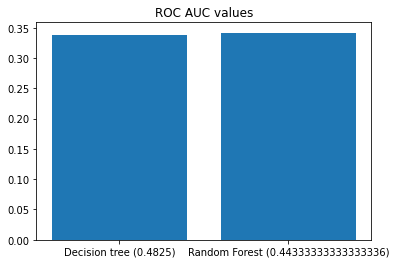

In [74]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(np.array(categories).reshape(-1, 1))
encoder.transform(np.array(y_test).reshape(-1, 1))


roc_auc_dectree = roc_auc_score(
    encoder.transform(np.array(y_test).reshape(-1, 1)).toarray(),
    encoder.transform(np.array(y_pred_tree).reshape(-1, 1)).toarray(), 
    multi_class='ovr'
)

roc_auc_rforest = roc_auc_score(
    encoder.transform(np.array(y_test).reshape(-1, 1)).toarray(),
    encoder.transform(np.array(y_pred_rforest).reshape(-1, 1)).toarray(), 
    multi_class='ovr'
)

fig, ax = plt.subplots()
ax.bar([f'Decision tree ({round(roc_auc_dectree, 5)})', f'Random Forest ({roc_auc_rforest})'], [roc_auc_ridgereg, roc_auc_logreg])
ax.set_title('ROC AUC values')

Значения ROC AUC также получились близки.
Подытоживая, лучшими ml моделями являются Decision Tree и Random Forest с оценкой f-1 score 0,48 b 0,44 соответсвенно.